In [1]:
import numpy as np
import xarray as xr
import cf_xarray as cfxr
import intake
import glob

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.gridspec import GridSpec
from matplotlib import ticker
import cmocean.cm as cm

from dask.distributed import Client

In [2]:
from os import environ
environ["PYTHONWARNINGS"] = "ignore"

client = Client(threads_per_worker = 1)
client

<Client: 'tcp://127.0.0.1:38161' processes=28 threads=28, memory=251.19 GiB>

In [5]:
pathsC = np.sort(glob.glob('/g/data/g40/akm157/model_output/mom6-panan/panant-01-zstar-ssp126-MW-only/*/*ocean_month_z.nc'))

#pancontrol01 = intake.open_esm_datastore('/home/272/kc5856/panantrial/experiment_datastore.json', columns_with_iterables=['variable'])
#pantrial01 = intake.open_esm_datastore('/home/272/kc5856/catalog_dir/experiment_datastore.json', columns_with_iterables=['variable'])

In [8]:
def preprocess(control):
    control = control[['thetao', 'so']].sel(yh = slice(None, -55))
    return control

control = xr.open_mfdataset(pathsC, preprocess = preprocess)

In [4]:
#control_SO = pancontrol01.search(variable="so", frequency="1mon").to_dask(chunks = {'time':'auto'})
#control_TEMP = pancontrol01.search(variable="thetao", frequency="1mon").to_dask(chunks = {'time':'auto'})

#trial_SO = pantrial01.search(variable="so", frequency="1mon").to_dask(chunks = {'time':'auto'})
#trial_TEMP = pantrial01.search(variable="thetao", frequency="1mon").to_dask(chunks = {'time':'auto'})

In [9]:
temperature_anomaly = control.thetao - control.thetao.isel(time=slice(0, 12)).cf.mean('time')
salinity_anomaly = control.thetao - control.thetao.isel(time=slice(0, 12)).cf.mean('time')

#temperature_anomaly = control_TEMP - control_TEMP.isel(time=slice(0, 12)).cf.mean('time')
#salinity_anomaly = control_SO - control_SO.isel(time=slice(0, 12)).cf.mean('time')

Next, we load cell area (denoted as $a(x,y,z)$) to construct the total ocean area as a function of depth, $A$, namely  

$A(z) = \sum_x \sum_y a(x,y,z)$

We load dxt and dyt and compute a masked version of cell area; we also use a slight hack to divide temperature by itself and thereby get a 3-dimensional cell area mask that is needed to create 
.

In [24]:
#dxt = pancontrol01.search(variable=["dxt"],path=".*output021.*").to_dask()['dxt']
#dyt = pancontrol01.search(variable=["dyt"],path=".*output021.*").to_dask()['dyt']
#cell_area = dxt * dyt
#cell_area = cell_area

## Make a mask to get vertical variation of area
#temp1 = control_TEMP.isel(time=0)
#cell_mask = temp1 / temp1

#total_area = (cell_area * cell_mask).cf.sum({'longitude', 'latitude'}).load()
#total_area = total_area

#area = pancontrol01.search(variable=["areacello"],path=".*output021.*").to_dask()['areacello']

area = xr.open_dataset('/g/data/g40/akm157/model_output/mom6-panan/panant-01-zstar-ssp126-MW-only/output030/20060101.ocean_static.nc')['areacello']

total_area = area.cf.sum({'longitude', 'latitude'}).load()

Now, the mean temperature at each time level can then be computed as

$T(z,t) = \frac{\sum_x \sum_y a(x,y,z) \, \tilde{\theta}(x,y,z,t)}{A(z)}$

where $T$ is the globally average temperature and $\tilde{\theta}$ is the anomaly of the conservative temperature.

In [25]:
### Temperature hovmoller
temperature_hov = (area * temperature_anomaly).cf.sum({'longitude', 'latitude'}) / total_area

### Salinity hovmoller
salinity_hov = (area * salinity_anomaly).cf.sum({'longitude', 'latitude'}) / total_area

In [26]:
temperature_hov = temperature_hov.compute()

/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/distributed/client.py:3357: UserWarning: Sending large graph of size 17.12 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


In [27]:
salinity_hov = salinity_hov.compute()

In [14]:
def plot_hovmoller(fsize = 14, date_format = mdates.DateFormatter('%Y')):
    
    # Set figures properties
    plt.rcParams['font.size'] = fsize
    plt.rcParams['xtick.labelsize'] = fsize-2
    plt.rcParams['ytick.labelsize'] = fsize-2
    
    fig = plt.figure(figsize = (10, 6))
    grid = GridSpec(100, 100)
    
    ax = [fig.add_subplot(grid[:30, :30]), fig.add_subplot(grid[:30, 33:63]),
          fig.add_subplot(grid[32:, :30]), fig.add_subplot(grid[32:, 33:63])]
    
    for i in range(len(ax)):
        ax[i].xaxis.set_major_formatter(date_format)
        ax[i].tick_params(axis='x', labelrotation=45)
        if i != 0 and i != 2:
            ax[i].set_yticklabels([]) 

    return fig, ax

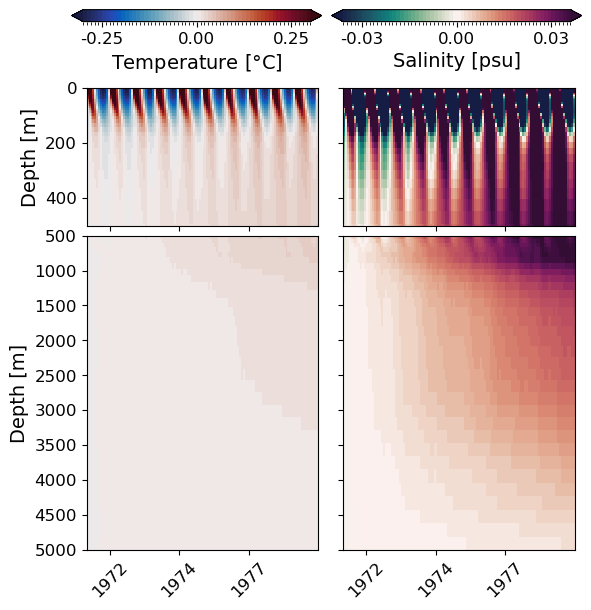

In [28]:
fig, ax = plot_hovmoller(fsize = 14)

levels_temperature = np.arange(-0.3, 0.31, 0.01)

cf_temp = temperature_hov.cf.plot(ax = ax[0],
                                  levels = levels_temperature,
                                  x = 'time',
                                  y = 'vertical',
                                  add_colorbar = False,
                                  label = None,
                                  cmap = cm.balance)

temperature_hov.cf.plot(ax = ax[2],
                        levels = levels_temperature,
                        x = 'time',
                        y = 'vertical',
                        add_colorbar = False,
                        label = None,
                        cmap = cm.balance)

levels_salinity = np.arange(-0.03, 0.031, 0.001)

cf_salt = salinity_hov.cf.plot(ax = ax[1],
                               levels = levels_salinity,
                               x = 'time',
                               y = 'vertical',
                               add_colorbar = False,
                               label = None,
                               cmap = cm.curl)

salinity_hov.cf.plot(ax = ax[3],
                     levels = levels_salinity,
                     x = 'time',
                     y = 'vertical',
                     add_colorbar = False,
                     label = None,
                     cmap = cm.curl)

## Beautification details
for i in range(len(ax)):
    if i < 2:
        ax[i].set_ylim(500, 0)
        ax[i].set_xticklabels([])
    else:
        ax[i].set_xlabel("")
        ax[i].set_ylim(5000, 500)
ax[0].set_ylabel("Depth [m]")
ax[1].set_ylabel("")
ax[2].set_ylabel("Depth [m]")
ax[3].set_ylabel("")

# Colorbars
bar = plt.axes([0.11, 0.99, 0.25, 0.02])
cbar_1 = plt.colorbar(cf_temp, cax = bar, orientation = 'horizontal', extend='both', format= '%.2f')  
cbar_1.set_label("Temperature [$\degree$C]")

bar = plt.axes([0.37, 0.99, 0.25, 0.02])
cbar_2 = plt.colorbar(cf_salt, cax = bar, orientation = 'horizontal', extend='both', format= '%.2f')  
cbar_2.set_label("Salinity [psu]")

for cbar in [cbar_1, cbar_2]:
    tick_locator = ticker.MaxNLocator(nbins=3) ## The ticker needs to called within the loop
    cbar.locator = tick_locator
    cbar.update_ticks()

In [23]:
temperature_hov.

<xarray.Dataset> Size: 600B
Dimensions:       (time: 0, z_l: 75)
Coordinates:
  * time          (time) object 0B 
  * z_l           (z_l) float64 600B 0.5413 1.681 2.94 ... 5.511e+03 5.709e+03
Data variables: (12/24)
    areacello     (time, z_l) float32 0B 
    deptho        (time, z_l) float32 0B 
    Coriolis      (time, z_l) float32 0B 
    geolon        (time, z_l) float32 0B 
    geolat        (time, z_l) float32 0B 
    geolon_c      (time, z_l) float32 0B 
    ...            ...
    dyCu          (time, z_l) float32 0B 
    dxCv          (time, z_l) float32 0B 
    dyCv          (time, z_l) float32 0B 
    areacello_cu  (time, z_l) float32 0B 
    areacello_cv  (time, z_l) float32 0B 
    areacello_bu  (time, z_l) float32 0B